In [10]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

plt.rcParams['figure.facecolor'] = 'white'
plt.style.use(['seaborn-talk'])

In [8]:
# Load the data
df = pd.read_csv('data/kc_housing_modifed.csv')
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode
0,1100000,2,1.75,2050,11900,1.0,0,2050,0,1950,0,98004
1,430000,3,1.50,1690,9708,1.5,0,1690,0,1954,0,98006
2,2150000,3,2.75,3470,9610,3.0,1,3470,0,1989,2000,98034
3,336000,4,2.50,2530,8169,2.0,0,2530,0,1993,0,98003
4,649500,3,3.00,3730,383328,1.5,0,2230,1500,1990,0,98038


In [9]:
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    
    """
    ## Make predictions and calculate residuals
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid, line='45',fit=True,ax=axes[0]);
    
    ## Homoscedascity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

In [11]:
# Load model from previous lesson
loaded_data = joblib.load('ols_results.joblib')
loaded_data.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'Outlier Scaler', 'Column Transformer', 'OLS Results'])

In [16]:
# Save the dictionary data into separate variables
X_train_df = loaded_data['X_train']
y_train = loaded_data['y_train']
X_test_df = loaded_data['X_test']
y_test = loaded_data['y_test']

# Save the model and processing tools
result = loaded_data['OLS Results']
outlier_scaler = loaded_data['Outlier Scaler']
preprocessor = loaded_data['Column Transformer']

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     187.3
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:47:28   Log-Likelihood:                -48210.
No. Observations:                3687   AIC:                         9.657e+04
Df Residuals:                    3610   BIC:                         9.705e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.972e+04   2814.752     -7.007

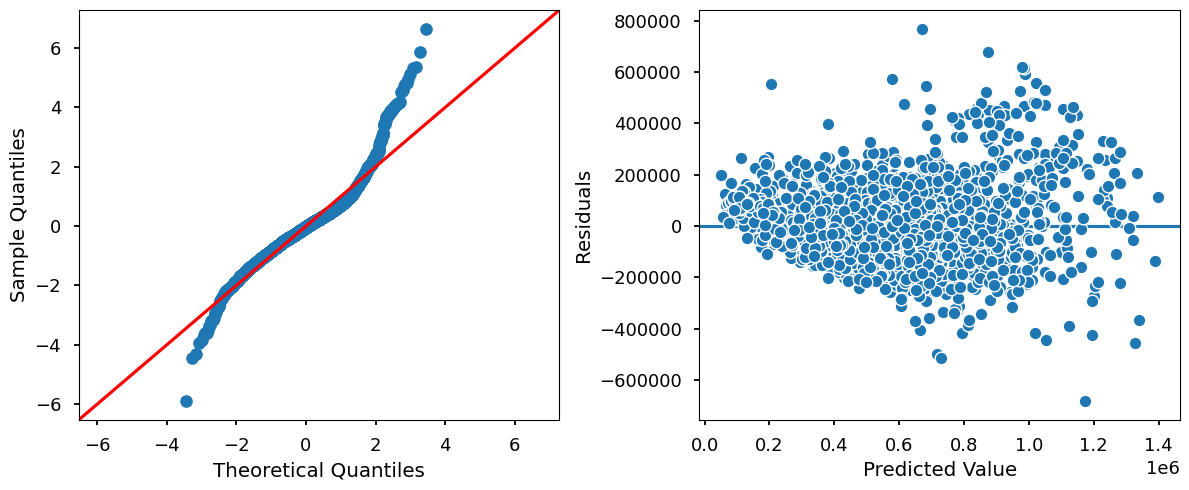

In [17]:
# Get the model metrics
print(result.summary())
evaluate_ols(result, X_train_df, y_train)

In [19]:
# Get the model coefficients and sort them
coeffs = result.params

bedrooms         -19723.359525
bathrooms         28172.329800
sqft_living         207.233425
floors           -41138.398629
waterfront       418376.338039
                     ...      
zipcode_98178   -158056.037850
zipcode_98188   -185179.202932
zipcode_98198   -190653.807548
zipcode_98199    221153.926332
const            177606.752950
Length: 78, dtype: float64

In [24]:
# Get the zipcode coefficients
zip_filter = coeffs.index.str.startswith('zipcode')
zip_coeffs = coeffs[zip_filter]

In [28]:
# Get the remaning coefficients
main_coeffs = coeffs[~zip_filter]
main_coeffs = main_coeffs.sort_values(ascending = False)
main_coeffs

waterfront       418376.338039
const            177606.752950
bathrooms         28172.329800
sqft_living         207.233425
yr_renovated         24.836621
sqft_basement       -73.783983
bedrooms         -19723.359525
floors           -41138.398629
dtype: float64

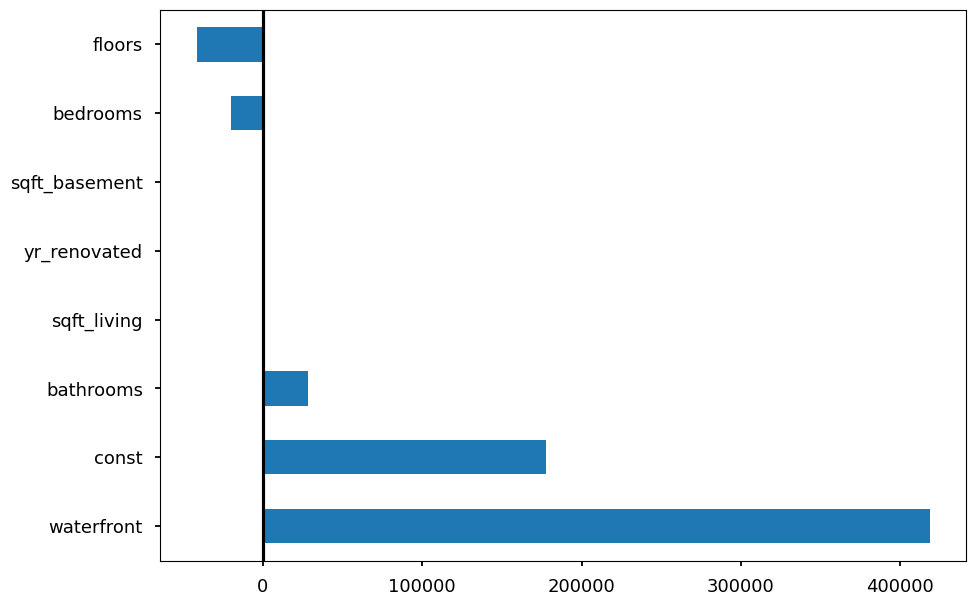

In [32]:
# Get a visual of the coefficients
main_coeffs.plot(kind = 'barh');
plt.axvline(0, color = 'k')

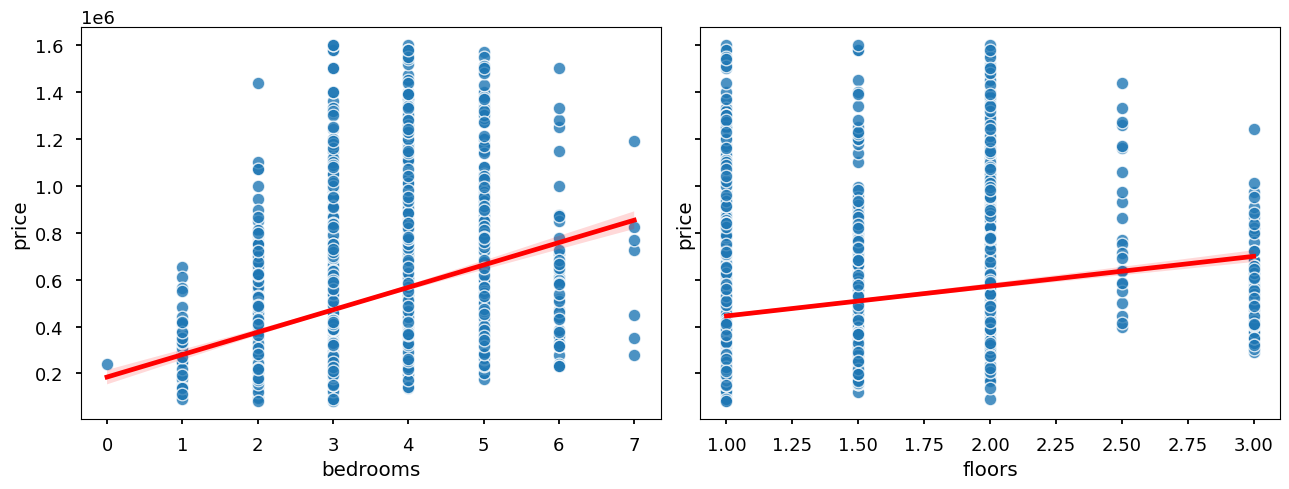

In [40]:
# Visualizing variables with large negative coefficients
fig, axes = plt.subplots(ncols = 2, figsize = (13, 5), sharey = True);
sns.regplot(x = X_train_df['bedrooms'], y = y_train,
            scatter_kws = {'ec': 'white', 'lw': 1},
            line_kws = {'color': 'red'}, 
            ax = axes[0]);
sns.regplot(x = X_train_df['floors'], y = y_train,
            scatter_kws = {'ec': 'white', 'lw': 1},
            line_kws = {'color': 'red'},
            ax = axes[1]);
plt.tight_layout()

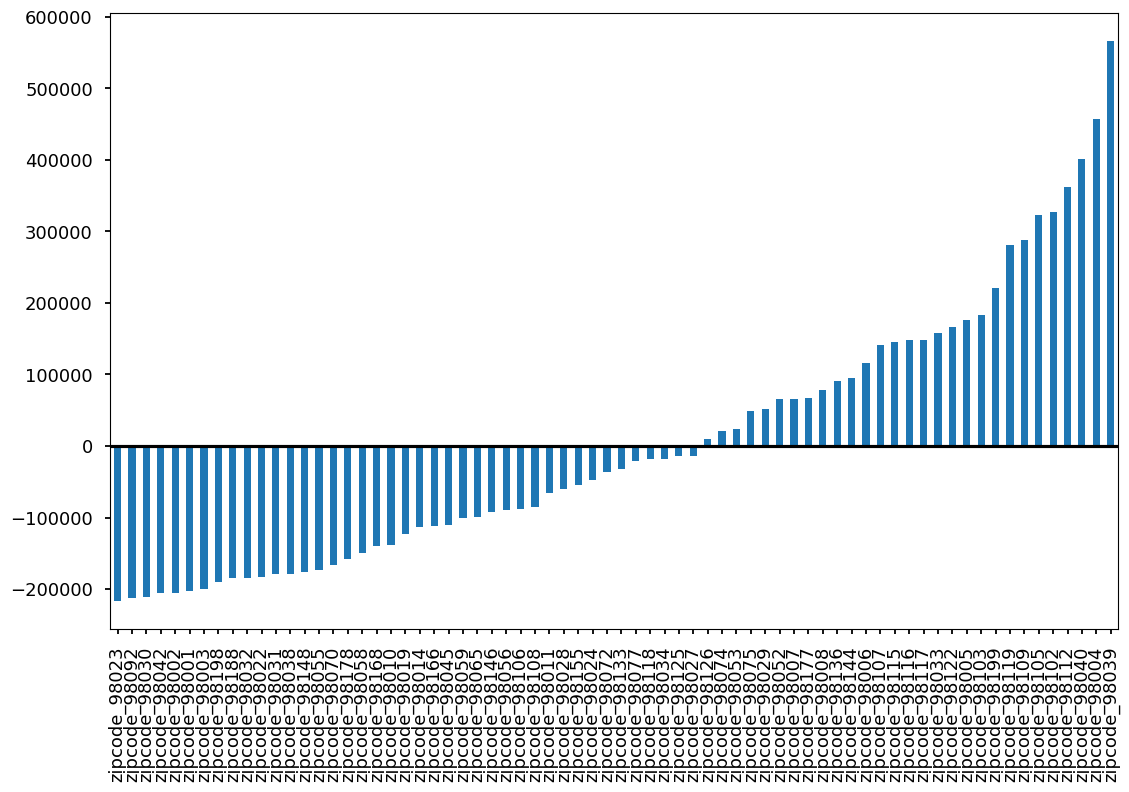

In [44]:
# Plot the coefficients for zip codes
ax = zip_coeffs.sort_values().plot(kind = 'bar', figsize = (13, 8));
ax.axhline(0, color = 'k');

In [46]:
# Train a model without zip codes
X_train_no_zip = X_train_df.loc[:, ~zip_filter]
model = sm.OLS(y_train, X_train_no_zip)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     438.9
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:26:55   Log-Likelihood:                -50037.
No. Observations:                3687   AIC:                         1.001e+05
Df Residuals:                    3679   BIC:                         1.001e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -2.776e+04   4479.432     -6.198      0.000   -3.65e+04    -1.9e+04
bathrooms      8776.0966   7034.183      1.248      0.212   -5015.186    2.26e+04
sqft_living     200.5980      6.379     31.445      0.000     188.091     213.105
floors         2.848e+04   7908.709      3.601      0.000     1.3e+04     4.4e+04
waterfront      2.93e+05   4.49e+04      6.518      0.000    2.05e+05    3.81e+05
sqft_basement    35.0586      9.224      3.801      0.000      16.975      53.143
yr_renovated     50.1540      7.948      6.310      0.000      34.570      65.737
const          1.159e+05   1.42e+04      8.149      0.000     8.8e+04    1.44e+05
==============================================================================
Omnibus:                      606.354   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1317.222
Skew:                           0.960   Prob(JB):                    9.31e-287
Kurtosis:                       5.211   Cond. No.                     3.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""